In [ ]:
import os
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
import os
from glob import glob
from PIL import Image

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
#math operations
import numpy as np
#machine learning
import cv2
import os
from random import shuffle
from tqdm import tqdm
import random
#for opening and loading image
from PIL import Image
#for preprocessing
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
#Doing One hot encoding as classifier has multiple classes
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from random import shuffle
#For augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#MobileNetV2 model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Model, layers
from numpy import loadtxt

import itertools
from sklearn.metrics import confusion_matrix,classification_report

from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
y_train = np.load("/content/drive/My Drive/Datasets/Skin_npy/y_train.npy")

In [ ]:
X_train = np.load("/content/drive/My Drive/Datasets/Skin_npy/x_train.npy")

In [ ]:
X_val = np.load("/content/drive/My Drive/Datasets/Skin_npy/x_validate.npy")

In [ ]:
y_val = np.load("/content/drive/My Drive/Datasets/Skin_npy/y_validate.npy")

In [ ]:
X_train.shape, X_val.shape

((7210, 192, 256, 3), (802, 192, 256, 3))

In [ ]:
y_train.shape, y_val.shape

((7210, 7), (802, 7))

In [ ]:
pre_trained_model = VGG19(input_shape=(192, 256, 3), include_top=False, weights="imagenet")

80134624/80134624 [==============================] - 5s 0us/step


In [ ]:
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False

print(len(pre_trained_model.layers))

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
22


In [ ]:
last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 6, 8, 512)


In [ ]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10)

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [ ]:
for layer in pre_trained_model.layers:
    print(layer.name)
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False

print(len(pre_trained_model.layers))

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
22


In [ ]:
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5,
                                            min_lr=0.000001, cooldown=2)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 128, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 128, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 128, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 64, 128)       0   

In [ ]:
batch_size = 64
epochs = 35
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/35
112/112 [==============================] - 220s 2s/step - loss: 1.4967 - acc: 0.6339 - val_loss: 0.9478 - val_acc: 0.6719 - lr: 1.0000e-04
Epoch 2/35
112/112 [==============================] - 208s 2s/step - loss: 1.0225 - acc: 0.6537 - val_loss: 0.8645 - val_acc: 0.7161 - lr: 1.0000e-04
Epoch 3/35
112/112 [==============================] - 209s 2s/step - loss: 0.9761 - acc: 0.6689 - val_loss: 0.8454 - val_acc: 0.6823 - lr: 1.0000e-04
Epoch 4/35
112/112 [==============================] - 209s 2s/step - loss: 0.9080 - acc: 0.6766 - val_loss: 0.8298 - val_acc: 0.6979 - lr: 1.0000e-04
Epoch 5/35
112/112 [==============================] - 209s 2s/step - loss: 0.8615 - acc: 0.6861 - val_loss: 0.7169 - val_acc: 0.7214 - lr: 1.0000e-04
Epoch 6/35
112/112 [==============================] - 209s 2s/step - loss: 0.8397 - acc: 0.6903 - val_loss: 0.8384 - val_acc: 0.7057 - lr: 1.0000e-04
Epoch 7/35
112/112 [====

In [ ]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

26/26 [==============================] - 9s 329ms/step - loss: 0.4986 - acc: 0.8354
Validation: accuracy = 0.835411  ;  loss_v = 0.498586


In [ ]:
model.save("/content/drive/My Drive/skin_model/VGG19.h5")

testing

In [ ]:
feats_test=np.load("/content/drive/My Drive/skin_cancer_dataset/feats_test.npy")
labels_test=np.load("/content/drive/My Drive/skin_cancer_dataset/labels_test.npy")

In [ ]:
x_test = feats_test.astype('float32')/255
y_test=to_categorical(labels_test,3)

In [ ]:
loss_test, acc_test = model.evaluate(x_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

63/63 [==============================] - 22s 349ms/step - loss: 0.5206 - acc: 0.8288
Test: accuracy = 0.828757  ;  loss = 0.520644


Text(0.5, 1.0, 'Training and validation loss')

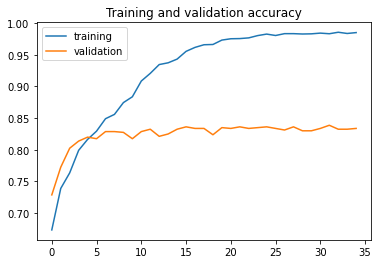

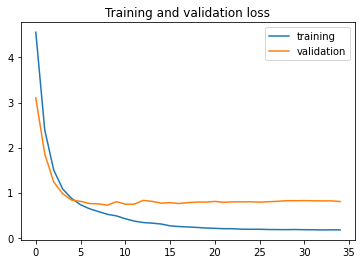

In [ ]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

In [ ]:
model = load_model('/content/drive/My Drive/skin_model/VGG19.h5')

In [ ]:
class_dict ={ 0: 'Melanocytic nevi',
     1: 'Melanoma',
     2: 'Benign keratosis-like lesions ',
     3: 'Basal cell carcinoma',
     4: 'Actinic keratoses',
     5: 'Vascular lesions',
     6: 'Dermatofibroma'
     }

In [ ]:
from keras.preprocessing.image import img_to_array

In [ ]:
from IPython.display import  display
def pred_image(img_path,model):
  img = Image.open(img_path).resize((224,224)) #target_size must agree with what the trained model expects!!
  # Preprocessing the image
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img.astype('float32')/255

  preds = model.predict(img)
  pred = np.argmax(preds,axis = 1)
  print(pred)
  #pred_cat = [k for k, v in class_dict.items() if v == pred[0]][0]

  return pred

5/5 [==============================] - 0s 48ms/step


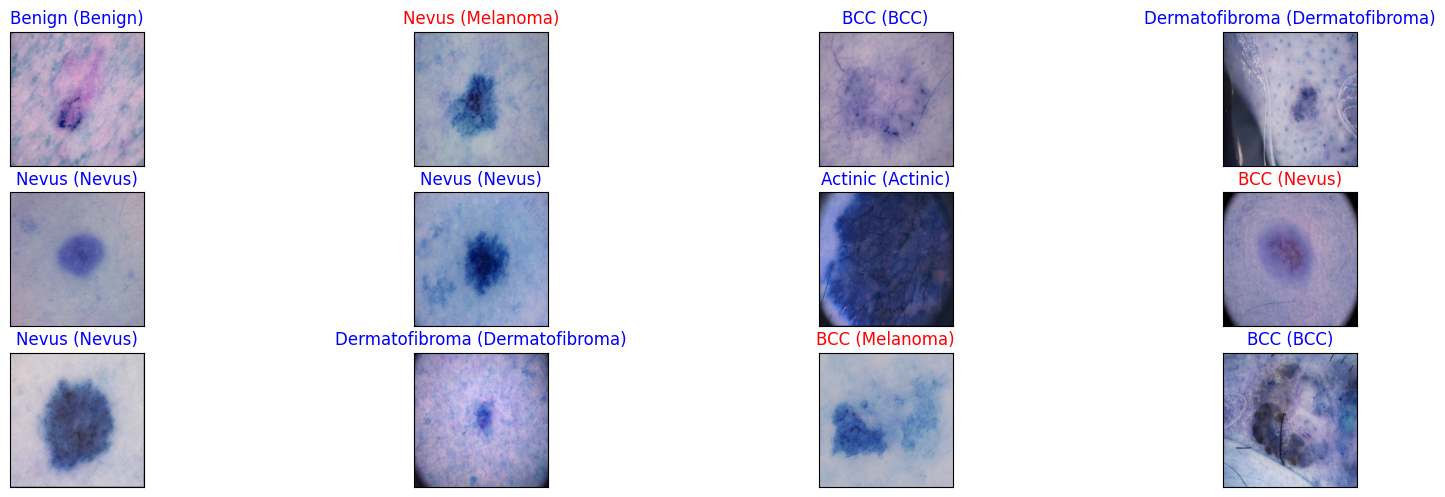

In [ ]:
y_hat = model.predict(x_test)

# define text labels
skin_labels = ['BCC','Melanoma','Nevus','Benign','Actinic','Vascuar','Dermatofibroma']

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=12, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    #print(pred_idx,true_idx)
    ax.set_title("{} ({})".format(skin_labels[pred_idx], skin_labels[true_idx]),
                color=("blue" if pred_idx == true_idx else "red"))